In [1]:
from manager import load_obj, save_obj
import numpy as np
import pandas as pd
import nltk 
import pyLDAvis
import pyLDAvis.gensim_models
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import string
import nltk
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from pprint import pprint
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

C:\Users\Tim\anaconda3\envs\bachelor\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\Tim\anaconda3\envs\bachelor\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Tim\anaconda3\envs\bachelor\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Tim\anaconda3\envs\bachelor\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Tim\anaconda3\envs\bachelor\lib\site-packages\setuptools\_distutils\version.py:351: Deprecatio

# Build a topic model

In [2]:
df = pd.read_csv("germanistik.csv", index_col=0)
df.head()

,text
link,
https://www.hausarbeiten.de/document/889420,\nInhalt:\n\n1. Einleitung: Der Text und das P...
https://www.hausarbeiten.de/document/1180614,\nInhaltsverzeichnis\n\n1 Einleitung\n2 Tieris...
https://www.hausarbeiten.de/document/1035784,"\nInhaltsverzeichnis\n\n1. Einleitung: Der ,lo..."
https://www.hausarbeiten.de/document/1005442,\nInhaltsverzeichnis\n\n1. Einleitung\n2. Zeit...
https://www.hausarbeiten.de/document/982747,\nEinleitung\nDie Ideale der Aufklärung schein...


In [3]:
len(df)

603

In [4]:
data = list(df.text)

In [5]:
len(data)

603

In [6]:
punctuation = [ c for c in string.punctuation ] + [u'\u201c',u'\u201d',u'\u2018',u'\u2019', u'\u201e', u"\u00bb", u"\u00ab", u"\u2026", "--"]


In [7]:
def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        sent = "".join(c for c in sentence if c not in punctuation)
        sent = "".join(c for c in sent if not c.isdigit())
        yield(nltk.word_tokenize(sent.lower(), language="german"))  # deacc=True removes punctuations

data = list(sent_to_words(data))



  0%|          | 0/603 [00:00<?, ?it/s]

In [8]:
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
print(trigram_mod[bigram_mod[data[1]]])

['inhaltsverzeichnis_einleitung', 'tierische', 'und', 'geistige', 'naturzusammenhänge', 'metamorphosen', 'eines', 'schwans', 'textanalyse', 'der', 'verbrecher', 'aus', 'verlorener_ehre', 'schlussbetrachtungen', 'literaturverzeichnis_einleitung', 'als', 'transfer', 'leistende', 'schriftstücke', 'definieren', 'friedrich', 'schillers', 'philosophische', 'abhandlungen', 'und', 'wissenschaftliche', 'studien', 'vielseitige', 'themenfelder', 'und', 'erleben', 'zumeist', 'eine', 'fortsetzung', 'in', 'seinen', 'fiktionalen', 'texten', 'die', 'vielseitigkeit', 'schillers', 'als', 'philosoph', 'und', 'mediziner', 'erweist', 'sich', 'für', 'sein', 'literarisches', 'werk', 'als', 'maßgebenden', 'nährboden', 'für', 'anthropologische', 'studien', 'so', 'kann', 'die', 'in', 'der', 'spätaufklärung', 'publizierte', 'erzählung', 'der', 'verbrecher', 'aus', 'verlorener_ehre', 'als', 'literarische', 'fortsetzung', 'zu', 'schillers', 'medizinischer', 'dissertation', 'versuch', 'über', 'den', 'z', 'usammenha

In [10]:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('de_core_news_md', disable=['parser', 'ner'])

# get stopwords from nltk library
stop_words = nltk.corpus.stopwords.words('german')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[w for w in doc if w not in stop_words and len(w) >= 3] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[w.lower() for w in doc if w not in stop_words and len(w) >= 3] for doc in texts_out]    
    
    return texts_out

In [11]:
data_ready = process_words(data)

  0%|          | 0/603 [00:00<?, ?it/s]

In [12]:
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 81413


In [13]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [14]:
dict_corpus = {}

for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [15]:
extension = dict_df[dict_df.freq>800].index.tolist()

In [16]:
extension

['anfang',
 'arbeit',
 'art',
 'aspekt',
 'auge',
 'ausdruck',
 'bedeutung',
 'element',
 'entwicklung',
 'fall',
 'figur',
 'form',
 'frage',
 'frau',
 'funktion',
 'geschichte',
 'gesellschaft',
 'gruppe',
 'handlung',
 'jahrhundert',
 'kritik',
 'kunst',
 'leben',
 'literatur',
 'mensch',
 'mittel',
 'person',
 'roman',
 'sprache',
 'stelle',
 'teil',
 'text',
 'thema',
 'vorstellung',
 'welt',
 'werk',
 'wirklichkeit',
 'wort',
 'zeichen',
 'zusammenhang',
 'analyse',
 'begriff',
 'beschreibung',
 'beziehung',
 'bezug',
 'bild',
 'buch',
 'darstellung',
 'ende',
 'erfahrung',
 'erzählung',
 'gedanke',
 'gefühl',
 'grund',
 'interpretation',
 'jahr',
 'kapitel',
 'kind',
 'leser',
 'mann',
 'motiv',
 'name',
 'natur',
 'situation',
 'struktur',
 'szene',
 'tag',
 'tier',
 'vater',
 'verbindung',
 'verhältnis',
 'zeit',
 'ziel',
 'aussage',
 'beispiel',
 'bereich',
 'film',
 'gegensatz',
 'möglichkeit',
 'problem',
 'realität',
 'sinn',
 'tod',
 'autor',
 'gott',
 'rolle',
 'seite',


In [17]:
# add high frequency words to stop words list
stop_words.extend(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

  0%|          | 0/603 [00:00<?, ?it/s]

Total Vocabulary Size: 85045


In [18]:
data_ready[1]

['inhaltsverzeichnis_einleitung',
 'naturzusammenhänge',
 'textanalyse',
 'verbrecher',
 'verlorener_ehre',
 'literaturverzeichnis_einleitung',
 'transfer',
 'schriftstücke',
 'abhandlung',
 'studie',
 'themenfelder',
 'fortsetzung',
 'text',
 'vielseitigkeit',
 'philosoph',
 'mediziner',
 'nährbod',
 'studie',
 'spätaufklärung',
 'verbrecher',
 'verlorener_ehre',
 'fortsetzung',
 'dissertation',
 'versuch',
 'usammenhang',
 'mensch',
 'abhandlung',
 'inwieweit',
 'körper',
 'wechselwirkung',
 'gleichgewicht',
 'empfindung',
 'mensch',
 'weiterführung',
 'dissertation',
 'konzept',
 'modell',
 'mensch',
 'hausarbeit',
 'forschungsansatz',
 'perspektive',
 'fragestellung',
 'hausarbeit',
 'funktion',
 'veränderung',
 'vorbild',
 'christian_wolf',
 'körper',
 'umsetzung',
 'frage',
 'hausarbeit',
 'mangelerscheinunge',
 'these',
 'äußere_erscheinungsbild',
 'funktion',
 'mangel',
 'zustand',
 'frage',
 'naturtriebe',
 'körper',
 'zeitraum',
 'zustand',
 'hausarbeit',
 'christian_wolfs',


In [19]:
# Filter out words that occur less than 10 documents, or more than
# 50% of the documents.
id2word.filter_extremes(no_below=15, no_above=0.6)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 3161


In [20]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [97]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:\\Users\\Tim\\Desktop\\bachelorarbeit\mallet-2.0.8'
mallet_path = 'C:\\Users\\Tim\\Desktop\\bachelorarbeit\\mallet-2.0.8\\bin\\mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12,id2word=id2word, optimize_interval=100, random_seed=101, iterations=1000)


<>:4: DeprecationWarning: invalid escape sequence \m
<>:4: DeprecationWarning: invalid escape sequence \m
C:\Users\Tim\AppData\Local\Temp\ipykernel_4588\1544773813.py:4: DeprecationWarning: invalid escape sequence \m
  os.environ['MALLET_HOME'] = 'C:\\Users\\Tim\\Desktop\\bachelorarbeit\mallet-2.0.8'


In [98]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(2,
  [('theater', 0.0413010413010413),
   ('stück', 0.03825903825903826),
   ('drama', 0.018544518544518544),
   ('bühne', 0.016906516906516907),
   ('publikum', 0.013630513630513631),
   ('inszenierung', 0.011641511641511641),
   ('zuschauer', 0.011583011583011582),
   ('kritiker', 0.01088101088101088),
   ('prinz', 0.009594009594009594),
   ('brecht', 0.008833508833508833)]),
 (0,
  [('held', 0.02323949475769834),
   ('ritter', 0.01902914224387022),
   ('kampf', 0.017171633781887227),
   ('könig', 0.016098406670519278),
   ('daz', 0.011929332122513002),
   ('list', 0.01172294229340378),
   ('minne', 0.011681664327581937),
   ('nibelungenlied', 0.008420705027656237),
   ('publikum', 0.006645752497316932),
   ('werk', 0.006356806736564022)]),
 (7,
  [('herz', 0.027968623208006492),
   ('herr', 0.026507979442791454),
   ('seele', 0.02153097105761428),
   ('liebe', 0.019583446037327562),
   ('geist', 0.01931295645117663),
   ('kirche', 0.017960508520421962),
   ('recht', 0.015850689748

In [4]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=15)] for n in range(0, ldamallet.num_topics)]

In [5]:
topics

[[('held', 0.023),
  ('ritter', 0.019),
  ('kampf', 0.017),
  ('könig', 0.016),
  ('daz', 0.012),
  ('list', 0.012),
  ('minne', 0.012),
  ('nibelungenlied', 0.008),
  ('publikum', 0.007),
  ('werk', 0.006),
  ('ehre', 0.006),
  ('märchen', 0.006),
  ('königin', 0.006),
  ('gegner', 0.006),
  ('quelle', 0.005)],
 [('idee', 0.013),
  ('wahrheit', 0.011),
  ('wesen', 0.009),
  ('wissenschaft', 0.009),
  ('erkenntnis', 0.008),
  ('seele', 0.008),
  ('aufklärung', 0.008),
  ('ding', 0.008),
  ('zustand', 0.007),
  ('mythos', 0.007),
  ('eigenschaft', 0.007),
  ('vernunft', 0.007),
  ('wort', 0.006),
  ('zweck', 0.006),
  ('existenz', 0.006)],
 [('theater', 0.041),
  ('stück', 0.038),
  ('drama', 0.019),
  ('bühne', 0.017),
  ('publikum', 0.014),
  ('inszenierung', 0.012),
  ('zuschauer', 0.012),
  ('kritiker', 0.011),
  ('prinz', 0.01),
  ('brecht', 0.009),
  ('dramas', 0.009),
  ('komödie', 0.008),
  ('freiheit', 0.008),
  ('wirkung', 0.008),
  ('person', 0.008)],
 [('gewalt', 0.041),
  (

In [49]:

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.49665174844160775


In [33]:
import os
os.environ['MALLET_HOME'] = 'C:\\Users\\Tim\\Desktop\\bachelorarbeit\mallet-2.0.8'
mallet_path = 'C:\\Users\\Tim\\Desktop\\bachelorarbeit\\mallet-2.0.8\\bin\\mallet'
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for num in tqdm(range(start, limit, step)):

        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num,id2word=id2word, optimize_interval=100, random_seed=101, iterations=1000)
        model_list.append(model)
     
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence(),)

    return model_list, coherence_values

<>:2: DeprecationWarning: invalid escape sequence \m
<>:2: DeprecationWarning: invalid escape sequence \m
C:\Users\Tim\AppData\Local\Temp\ipykernel_12196\3803749831.py:2: DeprecationWarning: invalid escape sequence \m
  os.environ['MALLET_HOME'] = 'C:\\Users\\Tim\\Desktop\\bachelorarbeit\mallet-2.0.8'


In [46]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=10, limit=20, step=2)

  0%|          | 0/5 [00:00<?, ?it/s]

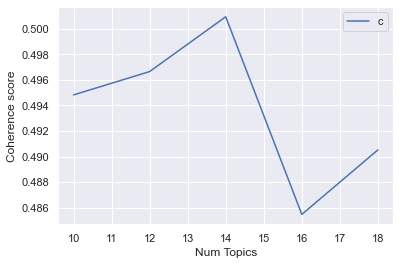

In [47]:
# Show graph
limit=20; start=10; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:


#import pickle
#pickle.dump(ldamallet, open("topic_model", "wb"))


In [2]:

import pickle
ldamallet = pickle.load(open("topic_model", "rb"))

In [8]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=[num_to_topic(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

C:\Users\Tim\AppData\Local\Temp\ipykernel_1536\1897107529.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Mittelalter,"held, ritter, kampf, könig, daz, list, minne, nibelungenlied, publikum, werk, ehre, märchen, königin, gegner, quelle"
Philosophie,"idee, wahrheit, wesen, wissenschaft, erkenntnis, seele, aufklärung, ding, zustand, mythos, eigenschaft, vernunft, wort, zweck, existenz"
"Theater, Drama und Tragödie","theater, stück, drama, bühne, publikum, inszenierung, zuschauer, kritiker, prinz, brecht, dramas, komödie, freiheit, wirkung, person"
Themen um Gewalt und Psychologie,"gewalt, identität, körper, krieg, blut, krankheit, kultur, figur, freud, sexualität, opfer, ring, lust, komik, wahnsinn"
Kommunikationswissenschaften,"äußerung, sprecher, musik, werbung, gespräch, kommunikation, partikel, ironie, medium, film, argumentation, sendung, aufforderung, verwendung, information"
Sprachgebrauch bei Kindern und Jugendlichen,"kind, wörter, abbildung, schüler, artikel, schrift, beispiel, untersuchung, text, übersetzung, buchstabe, gebrauch, regel, wörterbuch, person"
"Familienverhältnisse, Geschlechterrollen und Konflikte","frau, mann, tochter, sohn, kind, mädchen, freund, eltern, figur, konflikt, vater, liebe, haus, schwester, gefühl"
"Religion, Glaube und Kirche","herz, herr, seele, liebe, geist, kirche, recht, leute, ding, auge, faust, kraft, haus, wort, hand"
"Politische Systme, Kriegs- und Nachkriegsliteratur","volk, jude, land, schriftsteller, staat, autor, soldat, masse, politik, krieg, kultur, nationalsozialismus, heimat, bürger, regierung"
Textanalyse und Narratologie,"erzähler, figur, auge, traum, gedanke, erinnerung, vergangenheit, wort, raum, protagonist, ort, stadt, eindruck, schatten, spaziergang"


In [12]:
topics_df

,Terms per Topic
Mittelalter,"held, ritter, kampf, könig, daz, list, minne, nibelungenlied, publikum, werk, ehre, märchen, königin, gegner, quelle"
Philosophie,"idee, wahrheit, wesen, wissenschaft, erkenntnis, seele, aufklärung, ding, zustand, mythos, eigenschaft, vernunft, wort, zweck, existenz"
"Theater, Drama und Tragödie","theater, stück, drama, bühne, publikum, inszenierung, zuschauer, kritiker, prinz, brecht, dramas, komödie, freiheit, wirkung, person"
Themen um Gewalt und Psychologie,"gewalt, identität, körper, krieg, blut, krankheit, kultur, figur, freud, sexualität, opfer, ring, lust, komik, wahnsinn"
Kommunikationswissenschaften,"äußerung, sprecher, musik, werbung, gespräch, kommunikation, partikel, ironie, medium, film, argumentation, sendung, aufforderung, verwendung, information"
Sprachgebrauch bei Kindern und Jugendlichen,"kind, wörter, abbildung, schüler, artikel, schrift, beispiel, untersuchung, text, übersetzung, buchstabe, gebrauch, regel, wörterbuch, person"
"Familienverhältnisse, Geschlechterrollen und Konflikte","frau, mann, tochter, sohn, kind, mädchen, freund, eltern, figur, konflikt, vater, liebe, haus, schwester, gefühl"
"Religion, Glaube und Kirche","herz, herr, seele, liebe, geist, kirche, recht, leute, ding, auge, faust, kraft, haus, wort, hand"
"Politische Systme, Kriegs- und Nachkriegsliteratur","volk, jude, land, schriftsteller, staat, autor, soldat, masse, politik, krieg, kultur, nationalsozialismus, heimat, bürger, regierung"
Textanalyse und Narratologie,"erzähler, figur, auge, traum, gedanke, erinnerung, vergangenheit, wort, raum, protagonist, ort, stadt, eindruck, schatten, spaziergang"


In [7]:
def num_to_topic(num):
    
    if num == 1:
        return "Mittelalter"
    if num == 2:
        return "Philosophie"
    if num == 3:
        return "Theater, Drama und Tragödie"
    if num == 4:
        return "Themen um Gewalt und Psychologie"
    if num == 5:
        return "Kommunikationswissenschaften"
    if num == 6:
        return "Sprachgebrauch bei Kindern und Jugendlichen"
    if num == 7:
        return "Familienverhältnisse, Geschlechterrollen und Konflikte"
    if num == 8:
        return "Religion, Glaube und Kirche"
    if num == 9:
        return "Politische Systme, Kriegs- und Nachkriegsliteratur"
    if num == 10:
        return "Textanalyse und Narratologie"
    if num == 11:
        return "Sprachwissenschaft"
    if num == 12:
        return "Lyrik"

        
        

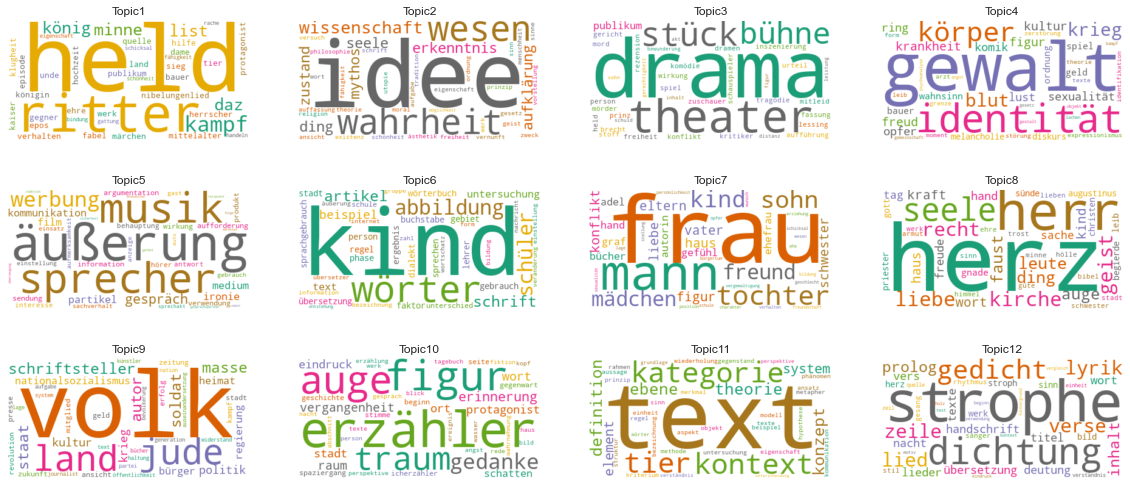

In [119]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(12):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [120]:
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [121]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [134]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

C:\Users\Tim\anaconda3\envs\bachelor\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [13]:
tm_results = ldamallet[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df["Link"] = df.iloc[:, 0]
corpus_topic_df["Dominant Topic"] = [item[0]+1 for item in corpus_topics]
corpus_topic_df["Contribution %"] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df["Topic Terms"] = [topics_df.iloc[t[0]]["Terms per Topic"] for t in corpus_topics]


NameError: name 'corpus' is not defined

In [14]:
topic_doc={}
for index, row in corpus_topic_df.iterrows():
    topic_doc[index] = row["Dominant Topic"]

NameError: name 'corpus_topic_df' is not defined

In [11]:
topic_doc={}
for index, row in corpus_topic_df.iterrows():
    topic_doc[index] = num_to_topic(row["Dominant Topic"])

NameError: name 'corpus_topic_df' is not defined

In [126]:
topic_doc

{'https://www.hausarbeiten.de/document/889420': 'Philosophie',
 'https://www.hausarbeiten.de/document/1180614': 'Themen um Gewalt und Psychologie',
 'https://www.hausarbeiten.de/document/1035784': 'Themen um Gewalt und Psychologie',
 'https://www.hausarbeiten.de/document/1005442': 'Theater, Drama und Tragödie',
 'https://www.hausarbeiten.de/document/982747': 'Familienverhältnisse, Geschlechterrollen und Konflikte',
 'https://www.hausarbeiten.de/document/976525': 'Themen um Gewalt und Psychologie',
 'https://www.hausarbeiten.de/document/944778': 'Themen um Gewalt und Psychologie',
 'https://www.hausarbeiten.de/document/945094': 'Familienverhältnisse, Geschlechterrollen und Konflikte',
 'https://www.hausarbeiten.de/document/542604': 'Textanalyse und Narratologie',
 'https://www.hausarbeiten.de/document/540954': 'Politische Systme, Kriegs- und Nachkriegsliteratur',
 'https://www.hausarbeiten.de/document/538434': 'Sprachwissenschaft',
 'https://www.hausarbeiten.de/document/535711': 'Textan

# Add topic to the works

In [127]:
works = load_obj("germanistik")
for work in works:
    if work.link in topic_doc:
        work.topic = topic_doc[work.link]

In [128]:
save_obj(works, "germanistik")

In [9]:
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

NameError: name 'corpus_topic_df' is not defined